# Описание задачи
____________

Датасет содержит сведения о 40 000 ресторанах Европы. Необходимо построить модель, которая должна быть способной предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

# Описание данных
__________
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvosor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# Шаг 1. Загрузка и предобработка данных
___________

### Загрузка библиотек и датасета
___________

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split, GridSearchCV
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn.metrics import mean_absolute_error # инструменты для оценки точности модели
from sklearn.preprocessing import OrdinalEncoder # OrdinalEncoder для присвоения порядковых номеров множеству данных


import re

from ipyleaflet import Map, Marker, Heatmap, Polygon, FullScreenControl, WidgetControl
import ipywidgets

In [3]:
df_train = pd.read_csv(r'C:\Data for Python\main_task.xls')
df_test = pd.read_csv(r'C:\Data for Python\kaggle_task.csv')
sample_submission = pd.read_csv(r'C:\Data for Python\sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [9]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


### Предобработка
_____________

Для более корректной обработки признаков необходимо объединить тренировочный и тестируемый датасеты в один общий датасет

In [10]:
df_train['sample'] = 1 # обозначение того,где тренировочный датасет
df_test['sample'] = 0 # обозначение того,где тестируемый датасет
df_test['Rating'] = 0 # в тесте нас нет значения Rating, его необходимо предсказать, на данный момент достаточно
# заполить его нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединение

In [11]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Сколько пропущенных значений имеется в датафрейме?

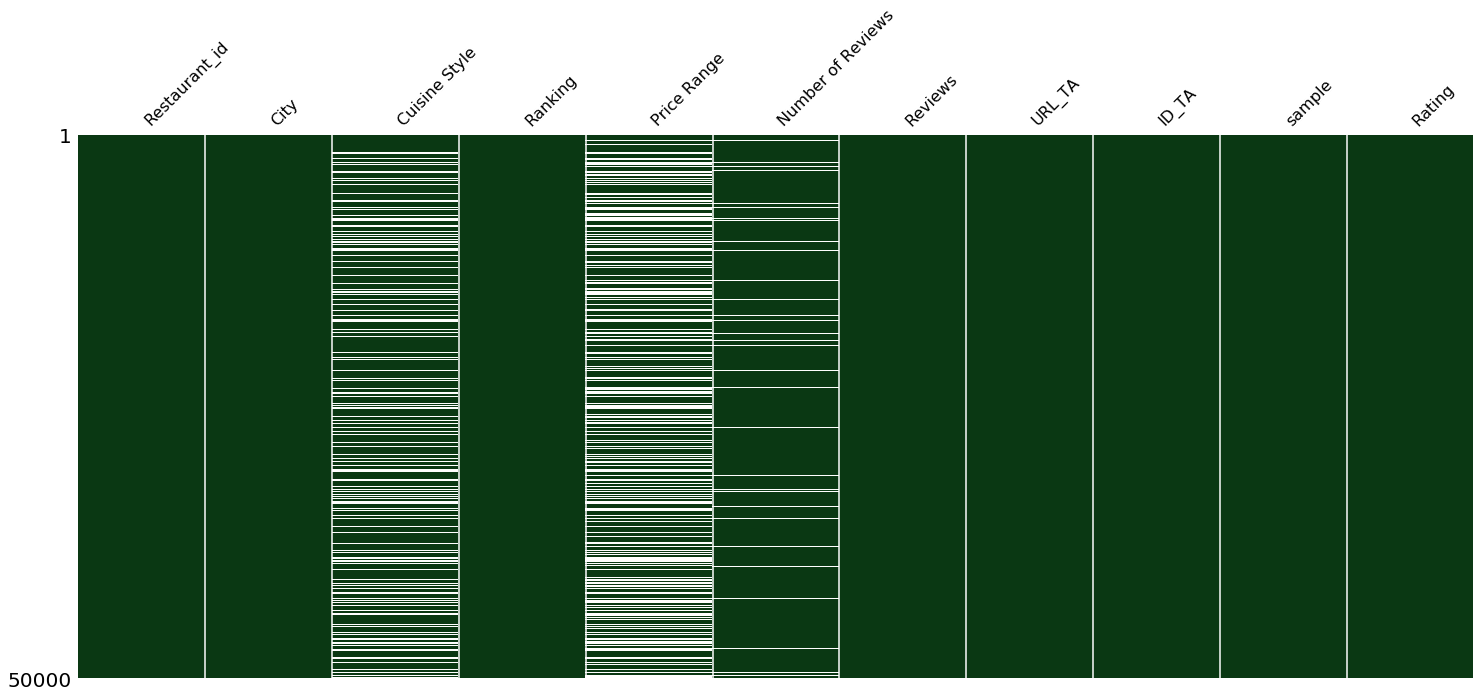

In [13]:
# Визуализация данных (белым цветом обозначены пропуски)

msno.matrix(data, color=(0.04, 0.221, 0.078), sparkline=False);

In [14]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

Имеются ли в данных дублированные значения?

In [15]:
data.duplicated().sum()

0

В данных наблюдается неверная запись названия признаков. Предлагается привести все названия к нижнему регистру и заменить пробелы нижним подчеркиванием

In [16]:
data.columns = map(str.lower, data.columns)

In [17]:
data.columns

Index(['restaurant_id', 'city', 'cuisine style', 'ranking', 'price range',
       'number of reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

In [18]:
data.rename(columns={'cuisine style': 'cuisine_style', 'price range': 'price_range',
                      'number of reviews': 'number_of_reviews'}, inplace=True)

Так как ссылка на отзыв о ресторане 'url_ta' является номинативным и не несет в себе полезной для дальнейшей работы функции, предлагается устранить данный набор значений

In [19]:
data.drop(labels='url_ta', axis=1, inplace=True)

Так как количество пропущенных значений, обозначающих количество отзывов, не больше 10 процентов от их общего числа, предлагается заполнить их 0. Ноль, также как и пропущенное значение, будет означать отсутствие отзывов

In [20]:
data['number_of_reviews'].fillna(0, inplace=True)

In [21]:
data.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",d1112354,0,0.0


## Вывод
_________________
Были загружены данные и объединены воедино 2 датасета, тренировочный и тестируемый. Для более корректной обработки признаков были объединены тренировочный и тестируемый датасеты в один общий датасет. Тренировочному датасету было присвоено значение 1 для каждого из наблюдений, а тестируемому значение 0, также по каждому из наблюдений. В названном, общем, датафрейме data отсутствуют дублирующиеся значения, однако в признаках cuisine_style, price_range присутствует критическое количество пустых значений, (11590, 17361) соответственно. Также имелись пропуски в признаке number_of_reviews, их количество незначительное (3200) и были заменены нулями. Оставшиеся пропущенные значения предлагается на данный момент оставить и заполнить при дальнейшей работе, приняв решение о заполнении, более подробно изучив данные. Устранение пустых значений не является целесообразным, так как будет потеряно четверть данных. Названия признаков были приведены к нижнему регистру, а также были заменены пробелы на символ нижнего подчеркивания. Признак 'url_ta' был полностью устранен, так как не несет в себе пользы для дальнейшей работы.


# Шаг 2. Анализ данных
________

В данном разделе следует более детально рассмотреть представленные признаки, и если целесообразно, создать новые признаки для дальнейшего построения модели

In [22]:
data

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",d1100838,1,4.0


### city
__________

Сколько и какие города представлены в наборе данных?

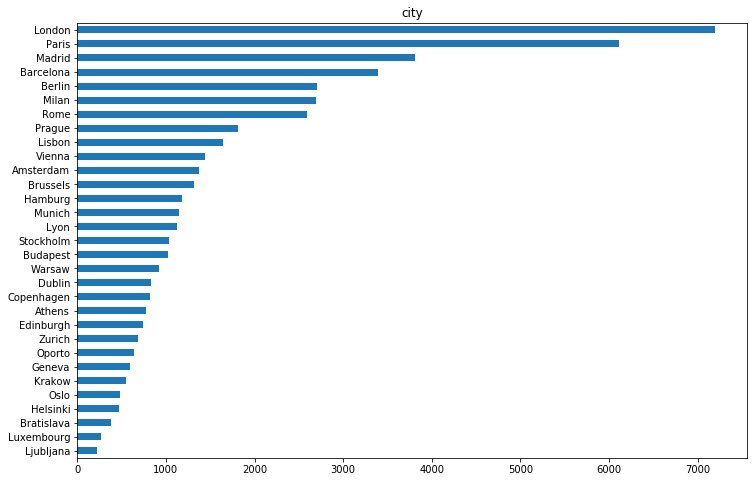

In [23]:
fig, ax  = plt.subplots(figsize=(12,8))

data['city'].value_counts(ascending=True).plot(kind='barh');

ax.set_title('city', size=12);

Подготовка данных для визуализации местонахождения городов

In [70]:
# Координаты добыты вручную с помощью сайта Google.com

coordinates = {'city': ['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome', 'Prague', 'Lisbon', 
                       'Vienna', 'Amsterdam', 'Brussels', 'Hamburg', 'Munich', 'Lyon', 'Stockholm', 
                       'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburg', 'Zurich',
                       'Oporto', 'Geneva', ' Krakow', ' Oslo', 'Helsinki', ' Bratislava', 'Luxenbourg', 'Ljubljana'],
               'lat': [51.5074, 48.8566, 40.4168, 41.3851, 52.5200, 45.4642, 41.9028, 50.0755, 38.7223,
                      48.2082, 52.3667, 50.8503, 53.5511, 48.1351, 45.7640, 59.3293, 47.4979, 52.2297,
                      53.3498, 55.6761, 37.9838, 55.9533, 47.3769, 41.1579, 46.2044, 50.0647, 59.9139,
                     60.1699, 48.1486, 49.8153, 46.0569],
               'long': [0.1278, 2.3522, -3.7038, 2.1734, 13.4050, 9.1900, 12.4964, 14.4378, -9.1393,
                       16.3738, 4.8945, 4.3517, 9.9937, 11.5820, 4.8357, 18.0686, 19.0402, 21.0122,
                       -6.2603, 12.5683, 23.7275, -3.1883, 8.5417, -8.6291, 6.1432, 19.9450, 10.7522,
                       24.9384, 17.1077, 6.1296, 14.5058]}

In [74]:
# Создание Датафрейма
coordinates_df = pd.DataFrame(coordinates)

Построение карты

In [72]:
europe = (54.5260, 15.2551) # координата Европы

europe_dot_map = Map(center=europe, zoom=4) # создание карты

for index, row in coordinates_df.iterrows(): # наложение значений на карту города
    marker = Marker(location=[row['lat'], row['long']], title=str(row['city']), draggable=False, opacity=.7)
    europe_dot_map.add_layer(marker)

    
    
# Создание кнопки полного контроля масштаба карты
control = FullScreenControl()   
# Добавление данной кнопки к карте
europe_dot_map.add_control(control)
# вывод
europe_dot_map 

Map(center=[54.526, 15.2551], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Наибольшая часть ресторанов представлена в западной Европе, однако диапазон практически равномерно распределен по всей территории Европы. Практически все города принадлежат разным странам за исключением:

* Германия: Берлин, Мюнхен, Гамбург

* Италия: Рим, Милан

* Франция: Париж, Лион

* Испания: Мадрид, Барселона

* Португалия: Лисcабон, Опорто

* Швейцария: Цюрих, Женева

Как в данных распределен ранг ресторанов, в первых, лидирующих по количеству ресторанов в датафейме, 10 городах? 

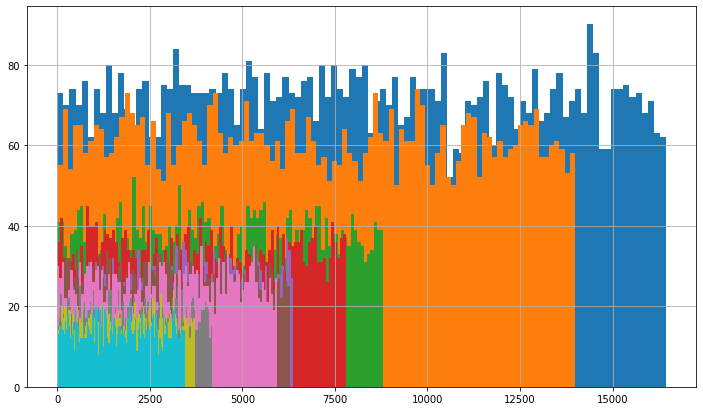

In [24]:
fig, ax = plt.subplots(figsize=(12,7))

for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

###  cuisine_style
_______

Предлагается рассмотреть количество и вариабельность кухонь, представленных не только в каждом ресторане, но во всем наборе данных

In [84]:
cuisine = data['cuisine_style'].copy()
cuisine.dropna(inplace=True)

In [85]:
cuisine = cuisine.str.strip('[]')
cuisine_df = pd.DataFrame(cuisine.str.split(',').tolist()).stack().reset_index([0])
cuisine_df.drop(['level_0'], axis=1, inplace=True)
cuisine_df.columns = ['cuisine']
cuisine_df['cuisine'] = cuisine_df['cuisine'].str.replace("'",'')
cuisine_df['cuisine'] = cuisine_df['cuisine'].str.strip(' ')
cuisine_df.reset_index(drop=True, inplace=True)

In [86]:
cuisine_df.head(12) # первые 12 значений

,cuisine
0,Bar
1,Pub
2,European
3,Scandinavian
4,Gluten Free Options
5,Vegetarian Friendly
6,Vegan Options
7,Vegetarian Friendly
8,Italian
9,Mediterranean


Сколько и какие уникальные значения содержит новый, созданный датафрейм

In [87]:
cuisine_df['cuisine'].nunique()

125

In [88]:
cuisine_df['cuisine'].unique()

array(['Bar', 'Pub', 'European', 'Scandinavian', 'Gluten Free Options',
       'Vegetarian Friendly', 'Vegan Options', 'Italian', 'Mediterranean',
       'Seafood', 'French', 'Cafe', 'Fast Food', 'Portuguese', 'Greek',
       'Czech', 'Eastern European', 'Central European', 'Pizza',
       'British', 'Spanish', 'Norwegian', 'African', 'Moroccan',
       'Middle Eastern', 'Halal', 'Indian', 'Thai', 'Dutch', 'Welsh',
       'American', 'Steakhouse', 'Soups', 'Scottish', 'Fusion',
       'Street Food', 'Hungarian', 'Asian', 'Wine Bar', 'Barbecue',
       'Central American', 'Peruvian', 'South American', 'Irish',
       'Polish', 'Vietnamese', 'Lebanese', 'Turkish', 'Healthy',
       'Japanese', 'Sushi', 'Austrian', 'Chinese', 'Danish',
       'International', 'Gastropub', 'Korean', 'German', 'Contemporary',
       'Arabic', 'Diner', 'Swiss', 'Swedish', 'Persian', 'Australian',
       'Grill', 'Mexican', 'Latin', 'Belgian', 'Argentinean', 'Tunisian',
       'Russian', 'Nepali', 'Bangladesh

Сколько вариаций кухонь в среднем приходится на один ресторан?

In [89]:
data['cuisine_style'].dropna().apply(lambda x: len(x.strip('[]').split(','))).mean()

3.1157511064826866

Число 125 немного преувеличенно, с учетом, что имеются такие совпадения, как Pizza и Italian, Pub и Irish, Sushi и Japanese, что является некоторым барьером в установление абсолютно уникальных значений, зависящее от самого типа кухни, а не вариаций названий или их ассоциативных аналогов. Для большей уверенности можно задать некоторый диапазон уникальных значений. Из полученных данных наглядно видно, что в датафрейме присутствует от 100 до 125 уникальных значений кухонь.

Какая кухня представлена в наибольшем количестве ресторанов?


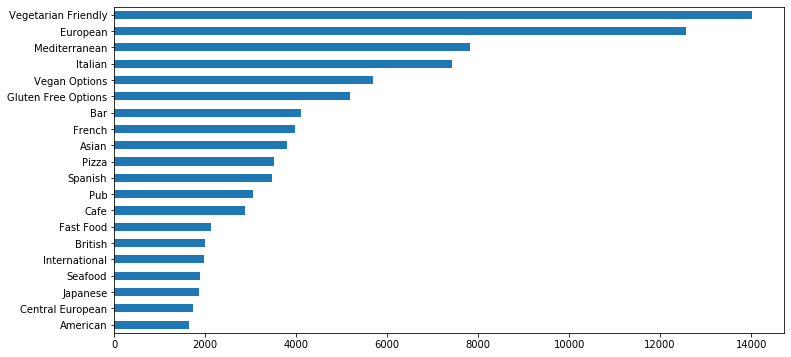

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))

cuisine_df['cuisine'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh');

Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует информация о типах кухонь, то будет считаться, что в этом ресторане предлагается только один тип кухни.

In [30]:
cuisineset = data['cuisine_style'].copy()
cuisineset.fillna('unknown', inplace=True) #заполним NaN типом str, обозначив пустое значение 'unknown'(неизвестно)
# Это поможет инструментарию pandas для дальнейшей работы со значениями типа str

In [31]:
cuisineset

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: cuisine_style, Length: 50000, dtype: object

In [32]:
round(cuisineset.apply(lambda x: len(x.strip('[]').strip("'").split(','))).mean(),1)

2.6

### ranking
____________


Как распределен ранг ресторанов?

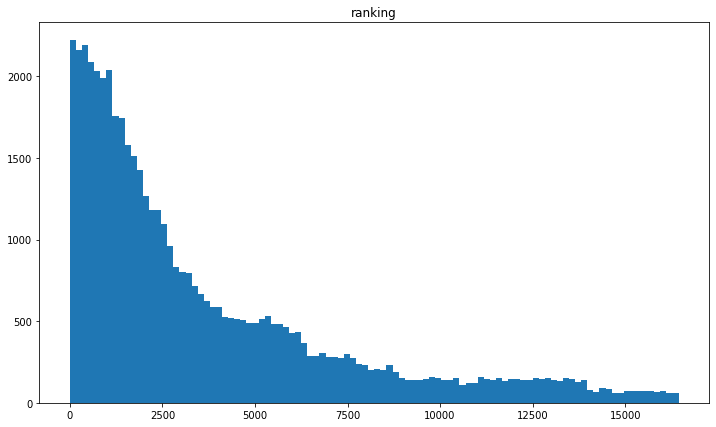

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.hist(data['ranking'], bins=100);

ax.set_title('ranking', size=12);

### price_range
________






In [34]:
data['price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

В признаке диапазона цены присутствует только 3 значения, что вероятно означает возможный диапазон размера чека (вероятно среднего)

In [35]:
data

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",d1100838,1,4.0


### number_of_reviews
____________

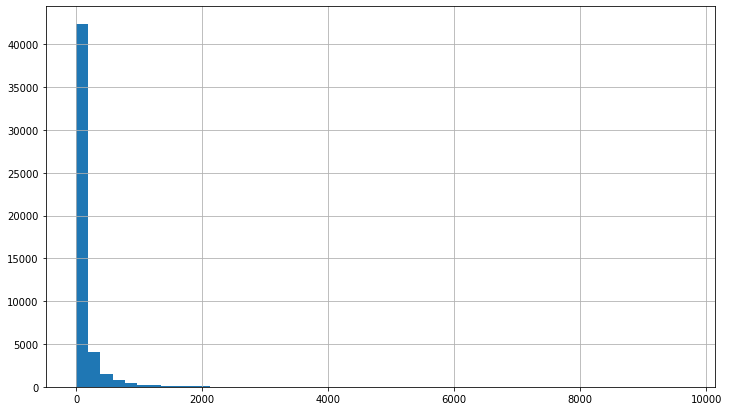

In [126]:
fig, ax = plt.subplots(figsize=(12, 7))

data['number_of_reviews'].hist(bins=50);

In [29]:
data['number_of_reviews'].describe()

count    50000.000000
mean       116.505040
std        286.173104
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

Как распределены количество отзывов по каждому городу?

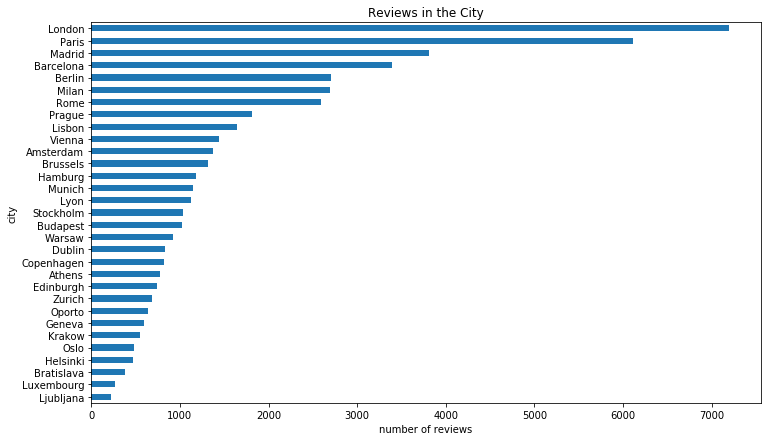

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))

data.groupby('city')['number_of_reviews'].count().sort_values(ascending=True).plot(kind='barh');

ax.set_xlabel('number of reviews');
ax.set_title('Reviews in the City', size=12);

### Reviews
__________
Пользу в данном признаке для текущей задачи несет только информация о времени публикации отзыва. Более глубокий семантический анализ не предусматривается. Информация о времени публикации будет рассмотрена в разделе создания признаков
_________


## Вывод
__________

Были более подробно рассмотрены признаки датафрейма.

При рассмотрении городов, было установлено, что наибольшая часть ресторанов представлена в западной Европе, однако диапазон практически равномерно распределен по всей территории Европы. Практически все города принадлежат разным странам за исключением:

* Германия: Берлин, Мюнхен, Гамбург

* Италия: Рим, Милан

* Франция: Париж, Лион

* Испания: Мадрид, Барселона

* Португалия: Лисабон, Опорто

* Швейцария: Цюрих, Женева

При изучении типов кухонь было установлено, что количество уникальных кухонь находится в диапазоне от 100 до 125 значений, а среднее количество кухонь, приходящееся на 1 ресторан равен 3. В предпочтениях значительно лидирует вегетарианская кухня, европейская, средиземноморская и итальянская. Более того, вегетарианской кухней заполнено 28% всех представленных ресторанов .

Ценовой диапазон чека представлен тремя значениями, что возможно говорит о среднем чеке каждого из ресторанов. В среднем ресторан собирает около 28 отзывов, большая часть значений сконцентрировано вокруг первой десятки. Имеются рестораны, которые набирают даже сотни и тысячи отзывов, однако таких ресторанов меньшинство. Вероятно, отзывов так много, потому что данные рестораны не только пользуются большим спросом, но и существуют достаточно долго, однако, может быть и так, что при введении данных была совершена ошибка.

Что касается самих отзывов, то данный признак остался без детального рассмотрения, так как в данной работе не предусматривается серьезный семантический анализ. Однако, в нем имеется информация о датах публикаций, которая может быть полезной, однако этот пункт оставлен для дальнейшей работы при создании новых признаков.



# Шаг 3. Создание новых признаков
________________

Создание значений, демонстрирующих ранг ресторана в контексте общего количества ресторанов в городе

In [157]:
# Выделение в словарь количество ресторанов
rest_count = data.groupby('city')['restaurant_id'].count().to_dict()

# Добавление количетсва ресторанов каждого города в отдельный признак
data['total_count_of_restaurants'] = data['city'].map(rest_count).astype('int16')

# Создание дополнительного признака (ранг ресторана относительно количество ресторанов в городе) 
# и оптимизация типов его значений
data['relative_ranking'] = data['ranking']/data['total_count_of_restaurants']

Создание нового признака, отражающий разницу между датами двух последних отзывов

In [156]:
# Извлечение необходимой информации и приведение ее к нужному виду
data['date_of_review'] = data['reviews'].str.findall('\d+/\d+/\d+')
data['date_of_review'].apply(lambda x: str(x).strip('[]'))

# Создание двух серий с датами отзывов (для последующего нахождения разницы значений)
Series_time = data['date_of_review'].apply(lambda x: pd.Series(x))

time_df = Series_time.drop(labels=2, axis=1)
time_df

# Поиск разницы между датами
timedelta = pd.to_datetime(time_df[0]) - pd.to_datetime(time_df[1])

# Вывод разницы в виде количества дней
timedelta = timedelta.apply(lambda x: abs(x.days))

# Заполнение пустых значений 0
timedelta.fillna(0, inplace=True)

# Приведение к типу int16 для сокращение нагрузки на рабочую память
timedelta = timedelta.astype('int16')

# Создание признака в основном датафрейме
data['timedelta'] = timedelta

Создание признака, указывающий на количество стилей кухонь в каждом ресторане

In [252]:
data['cuisine_count'] = data['cuisine_style']

data['cuisine_count'].fillna('[three, variables, are needed]', inplace=True)
data['cuisine_count'] = data['cuisine_count'].apply(lambda x: len(x.strip('[]').split(',')))

## Вывод
_____________

Было создано 3 дополнительных признака

* Относительный ранг ресторана ( место, которое он занимает среди всех ресторанов в своем городе, по отношению к общему количество всех ресторанов в городе)

Мотивация: предполагается, что данная метрика связана с реальным спросом на ресторан, а значит способна поспособствовать определению его рейтинга.

* Разница во времени между двумя последними отзывами

Мотивация: данная метрика, возможно, укажет на посещаемость и  актуальность ресторана. Если даты стоят близко, это означает высокий спрос и количество оставляемых отзывов. К сожалению, предоставленных дат в данных всего две, однако если иметь диапазон, хотя бы в 100 значений, то это лучше бы смогло отразить текущую идею.

* Количество стилей кухонь в каждом ресторане

Мотивация: возможно, разнообразие блюд также способствует увеличению рейтинга ресторана.

# Шаг 4. Обработка необходимых признаков и построение модели 
______________

На данном этапе будут выбраны необходимые признаки датафрейма. Дополнительно необходимо преобразовать некоторые типы значений к количественному виду, для того, чтобы не терять информацию о ресторанах и иметь возможность использовать ее при построении модели. 

### Обработка
_________

Предлагается работать в копии документа, чтобы при изменениях данных не искажать первоначальный датафрейм

In [405]:
df = data.query('sample == 1').drop(['sample'], axis=1).copy()

Избавление от ненужных признаков

In [406]:
df.drop(['restaurant_id', 'reviews', 'date_of_review', 'id_ta'], axis=1, inplace=True)

In [407]:
df.head()

,city,cuisine_style,ranking,price_range,number_of_reviews,rating,total_count_of_restaurants,timedelta,relative_ranking,cuisine_count
10000,Paris,"['European', 'French', 'International']",5570.0,$$ - $$$,194.0,3.5,6108,41,0.911919,3
10001,Stockholm,NaN,1537.0,NaN,10.0,4.0,1033,382,1.487899,3
10002,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,$$$$,688.0,4.5,7193,2,0.049075,7
10003,Berlin,NaN,3458.0,NaN,3.0,5.0,2705,0,1.278373,3
10004,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,$$ - $$$,84.0,4.0,1145,272,0.542358,3


В основном, набор блюд в признаке cuisine_style имеет схожую стилистику. Предлагается взять первое значение видов кухонь каждого ресторана, чтобы в дальнейшем закодировать данные, переведя их из категориального типа в числовой.

In [408]:
df['cuisine_style'] = df['cuisine_style'].fillna('na')
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: x.strip('[]').replace("'", "").split(',')[0])

Так как в признаке price_range имеется 13886 пропусков, что соответствует практически трети наблюдений (что означает, что удаление данных будет являться значительной потерей), взамен их устранения предлагается присвоить дополнительное категориальное значение для дальнейшей кодировки.

In [409]:
df['price_range'].fillna('na', inplace=True)

Оптимизация значений, приемлемая для того, чтобы не перегружать память вычислительной машины при ее работе

In [410]:
df['ranking'] = df['ranking'].astype('int16') 

In [411]:
df.head()

,city,cuisine_style,ranking,price_range,number_of_reviews,rating,total_count_of_restaurants,timedelta,relative_ranking,cuisine_count
10000,Paris,European,5570,$$ - $$$,194.0,3.5,6108,41,0.911919,3
10001,Stockholm,na,1537,na,10.0,4.0,1033,382,1.487899,3
10002,London,Japanese,353,$$$$,688.0,4.5,7193,2,0.049075,7
10003,Berlin,na,3458,na,3.0,5.0,2705,0,1.278373,3
10004,Munich,German,621,$$ - $$$,84.0,4.0,1145,272,0.542358,3


Заполнение пропусков признака number_of_reviews медианным значением. Данное решение связано с тем, что количество пропусков в данном признаке не является критическим, не превышая и 10% наблюдений, так же, медиана будет предпочтительнее среднего, так как в данных имеются слишком удаленные от средних показателей значения.

In [412]:
df['number_of_reviews'].fillna(28, inplace=True)

df['number_of_reviews'] = df['number_of_reviews'].astype('int16')
# оптимизация значений

Какие признаки в датафрейме для построения модели остались категориальными? 

In [413]:
categorical_features = list()
for column in df.columns:
    if df[column].dtype == 'object':
        categorical_features.append(column)
categorical_features.insert(2, 'ranking')
categorical_features

['city', 'cuisine_style', 'ranking', 'price_range']

Данные признаки предлагается закодировать и перевести в числовые значения с помощью метода OrdinalEncoder

In [414]:
encoder = OrdinalEncoder()

Применение энкодера на имеющихся признаках

In [415]:
encoder.fit(df[categorical_features])

ordinal_data = encoder.transform(df[categorical_features]) 

In [416]:
# Результат
pd.DataFrame(ordinal_data)

,0,1,2,3
0,24.0,37.0,5479.0,1.0
1,27.0,107.0,1536.0,3.0
2,16.0,58.0,352.0,2.0
3,3.0,107.0,3449.0,3.0
4,21.0,44.0,620.0,1.0
...,...,...,...,...
39995,20.0,57.0,499.0,1.0
39996,24.0,40.0,6191.0,1.0
39997,27.0,58.0,1651.0,3.0
39998,29.0,76.0,640.0,1.0


In [417]:
# Замена имеющихся категориальных значений их количественными аналогами
df[categorical_features] = ordinal_data

In [418]:
df.head()

,city,cuisine_style,ranking,price_range,number_of_reviews,rating,total_count_of_restaurants,timedelta,relative_ranking,cuisine_count
10000,24.0,37.0,5479.0,1.0,194,3.5,6108,41,0.911919,3
10001,27.0,107.0,1536.0,3.0,10,4.0,1033,382,1.487899,3
10002,16.0,58.0,352.0,2.0,688,4.5,7193,2,0.049075,7
10003,3.0,107.0,3449.0,3.0,3,5.0,2705,0,1.278373,3
10004,21.0,44.0,620.0,1.0,84,4.0,1145,272,0.542358,3


## Вывод
______________

В процессе подготовки данных были закодированы 4 категориальных признака, оптимизированы числовые и заменены пустые значения

Итоговый набор рассматриваемых признаков для дальнейшего построения модели:

* город ( city )
* стиль кухни ( cuisine_style )
* место, которое занимает данный ресторан среди всех ресторанов своего города ( ranking )
* ценовой диапазон ( price_range )
* количество отзывов ( number_of_reviews )
* рейтинг (целевая переменная) ( rating ) 
* общее количество ресторанов в городе ( total_count_of_restaurants )
* разница во времени между последними двумя отзывами ( timedelta )
* место, которое занимает данный ресторан среди всех ресторанов своего города, по отношению к количеству ресторанов в городе     ( relative_ranking )
* число стилей кухонь в ресторане ( cuisine_count )


### Построение модели
___________

Следует сделать разбиение тестовых и тренировочных данных

In [419]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['rating'].values # целевая переменная
X = df.drop(['rating'], axis=1)

In [420]:
X

,city,cuisine_style,ranking,price_range,number_of_reviews,total_count_of_restaurants,timedelta,relative_ranking,cuisine_count
10000,24.0,37.0,5479.0,1.0,194,6108,41,0.911919,3
10001,27.0,107.0,1536.0,3.0,10,1033,382,1.487899,3
10002,16.0,58.0,352.0,2.0,688,7193,2,0.049075,7
10003,3.0,107.0,3449.0,3.0,3,2705,0,1.278373,3
10004,21.0,44.0,620.0,1.0,84,1145,272,0.542358,3
...,...,...,...,...,...,...,...,...,...
49995,20.0,57.0,499.0,1.0,79,2694,34,0.185598,4
49996,24.0,40.0,6191.0,1.0,542,6108,9,1.038147,5
49997,27.0,58.0,1651.0,3.0,4,1033,3127,1.599226,2
49998,29.0,76.0,640.0,1.0,70,925,23,0.692973,5


In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Были проведены расчеты для установки наилучших настроек модели.


    param_grid = {'n_estimators': list(np.arange(100, 220, 20)), 'max_depth': list(np.arange(10, 60, 10))}

    param_grid

        param_search = GridSearchCV(estimator=ranfor, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)

    %%time

    param_search.fit(X_train, y_train)

    print(param_search.best_params_)

    print(param_search.best_score_)
    
    
max_depth = 20 n_est = 200 ( необходимые значения )

In [422]:
ranfor = RandomForestRegressor(n_estimators=200, verbose=1, n_jobs=-1, random_state=42, max_depth=20) 

In [423]:
ranfor.fit(X_train, y_train)

predictions = ranfor.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


In [424]:
predictions

array([4.61916332, 4.8625    , 4.31830958, ..., 4.57747869, 4.18174564,
       4.03288985])

Требуется округлить результаты. Допустимый числовой шаг в рейтинге на сайте Tripadvisor составляет 0.5.

In [425]:
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [426]:
for i in range(len(predictions)):
    predictions[i] = fine_rating_pred(predictions[i])

In [427]:
predictions

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [428]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))

Mean Absolute Error: 0.1766875


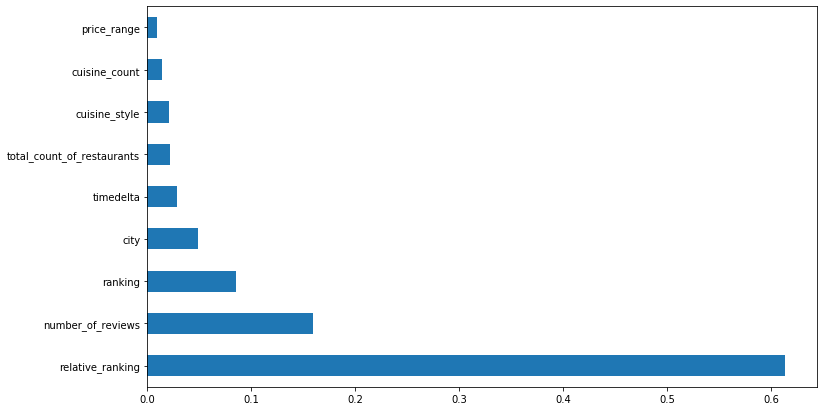

In [429]:
fig, ax = plt.subplots(figsize=(12, 7))

feat_importances = pd.Series(ranfor.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

_____________________________

# Общий вывод
_____

## Баг-репорт
___________

В предоставленных данных наблюдались отсутствующие значения у признаков:
* Cuisine Style        11590
* Price Range          17361
* Number of Reviews     3200
* Reviews                  2

Также были заменены названия признаков.

Иных проблем не обнаружено


## Результат выполненной работы
_____________

В данной работе были подробно исследованы признаки датафрейма, а также построена модель, предсказывающая рейтинг ресторана. 

При рассмотрении городов, было установлено, что наибольшая часть ресторанов представлена в западной Европе, однако диапазон практически равномерно распределен по всей территории Европы. Практически все города принадлежат разным странам за исключением:

* Германия: Берлин, Мюнхен, Гамбург

* Италия: Рим, Милан

* Франция: Париж, Лион

* Испания: Мадрид, Барселона

* Португалия: Лисабон, Опорто

* Швейцария: Цюрих, Женева

При изучении типов кухонь было установлено, что количество уникальных кухонь находится в диапазоне от 100 до 125 значений, а среднее количество кухонь, приходящееся на 1 ресторан равен 3. В предпочтениях значительно лидирует вегетарианская кухня, европейская, средиземноморская и итальянская. Более того, вегетарианской кухней заполнено 28% всех представленных ресторанов .

Ценовой диапазон чека представлен тремя значениями, что возможно говорит о среднем чеке каждого из ресторанов. В среднем ресторан собирает около 28 отзывов, большая часть значений сконцентрировано вокруг первой десятки. Имеются рестораны, которые набирают даже сотни и тысячи отзывов, однако таких ресторанов меньшинство. Вероятно, отзывов так много, потому что данные рестораны не только пользуются большим спросом, но и существуют достаточно долго, однако, может быть и так, что при введении данных была совершена ошибка.

Что касается самих отзывов, то данный признак остался без детального рассмотрения, так как в данной работе не предусматривается серьезный семантический анализ. Однако, в нем имеется информация о датах публикаций, которая может быть полезной, однако этот пункт оставлен для дальнейшей работы при создании новых признаков.

В дальнейшем было создано 3 дополнительных признака.

* Относительный ранг ресторана ( место, которое он занимает среди всех ресторанов в своем городе, по отношению к общему количество всех ресторанов в городе)

* Разница во времени между двумя последними отзывами

* Количество стилей кухонь в каждом ресторане

На финальной стадии подготовки данных для построения модели были отобраны следующие признаки и создан для них отдельный датафрейм.

* город ( city )
* стиль кухни ( cuisine_style )
* место, которое занимает данный ресторан среди всех ресторанов своего города ( ranking )
* ценовой диапазон ( price_range )
* количество отзывов ( number_of_reviews )
* рейтинг (целевая переменная) ( rating ) 
* общее количество ресторанов в городе ( total_count_of_restaurants )
* разница во времени между последними двумя отзывами ( timedelta )
* место, которое занимает данный ресторан среди всех ресторанов своего города, по отношению к количеству ресторанов в городе     ( relative_ranking )
* число стилей кухонь в ресторане ( cuisine_count )



После проведения испытаниий модель продемонстрировала среднюю абсолютную ошибку 0.1766875. Предсказанные значения пришлось округлить с шагом 0.5, чтобы результат соответствовал стилистике рейтинга Tripadvisor. Наиболее значимыми признаками оказались:
* место, которое занимает данный ресторан среди всех ресторанов своего города, по отношению к количеству ресторанов в городе     ( relative_ranking )
* количество отзывов ( number_of_reviews )
* место, которое занимает данный ресторан среди всех ресторанов своего города ( ranking )
* город ( city )

C учетом того, что relative_ranking является искусственно созданной из данных метрикой, сложно интерпретируемой в данной задачи, было интересно установить, какую среднюю абсолютную ошибку показала бы модель без ее учета. Значение составило 0.178125, что отличается от раннее выведенной ошибки ,с учетом признака, всего лишь на 0.00143. Следовательно, данный признак не играет практически никакой роли и является излишним в силу своей искусственности. Его можно оставить только исходя из того, что его наличие незначительно, но уменьшает показатель ошибки. Однако, как было доказано, в дальнейшем, модель можно использовать и без наличия relative_ranking.
